# 20기 Time Series 정규세션 과제

### Electric_Production.csv 데이터를 활용하여 자유롭게 시계열분석을 진행해주세요.
첨부한 '시계열자료_실습.ipynb' 코드를 참고하셔도 좋습니다.


### Box-Jenkins 방법론
![image.png](attachment:image.png)

### Prophet
튜토리얼 : https://hyperconnect.github.io/2020/03/09/prophet-package.html

## 라이브러리 불러오기

In [1]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.9 MB/s eta 0:00:00


In [17]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from pmdarima import arima
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX


## 데이터 불러오기

In [3]:
samsung_df = yf.download('005930.KS',
                      start='2020-01-01',
                      end='2021-04-21',
                      progress=False)

samsung_df = samsung_df[["Close"]]

samsung_df = samsung_df.reset_index()

samsung_df.columns = ['day', 'price']

samsung_df['day'] = pd.to_datetime(samsung_df['day'])

samsung_df.index = samsung_df['day']
samsung_df.set_index('day', inplace=True)

samsung_df

,price
day,
2020-01-02,55200.0
2020-01-03,55500.0
2020-01-06,55500.0
2020-01-07,55800.0
2020-01-08,56800.0
...,...
2021-04-14,84000.0
2021-04-15,84100.0
2021-04-16,83900.0


In [4]:
samsung_df.head()

,price
day,
2020-01-02,55200.0
2020-01-03,55500.0
2020-01-06,55500.0
2020-01-07,55800.0
2020-01-08,56800.0


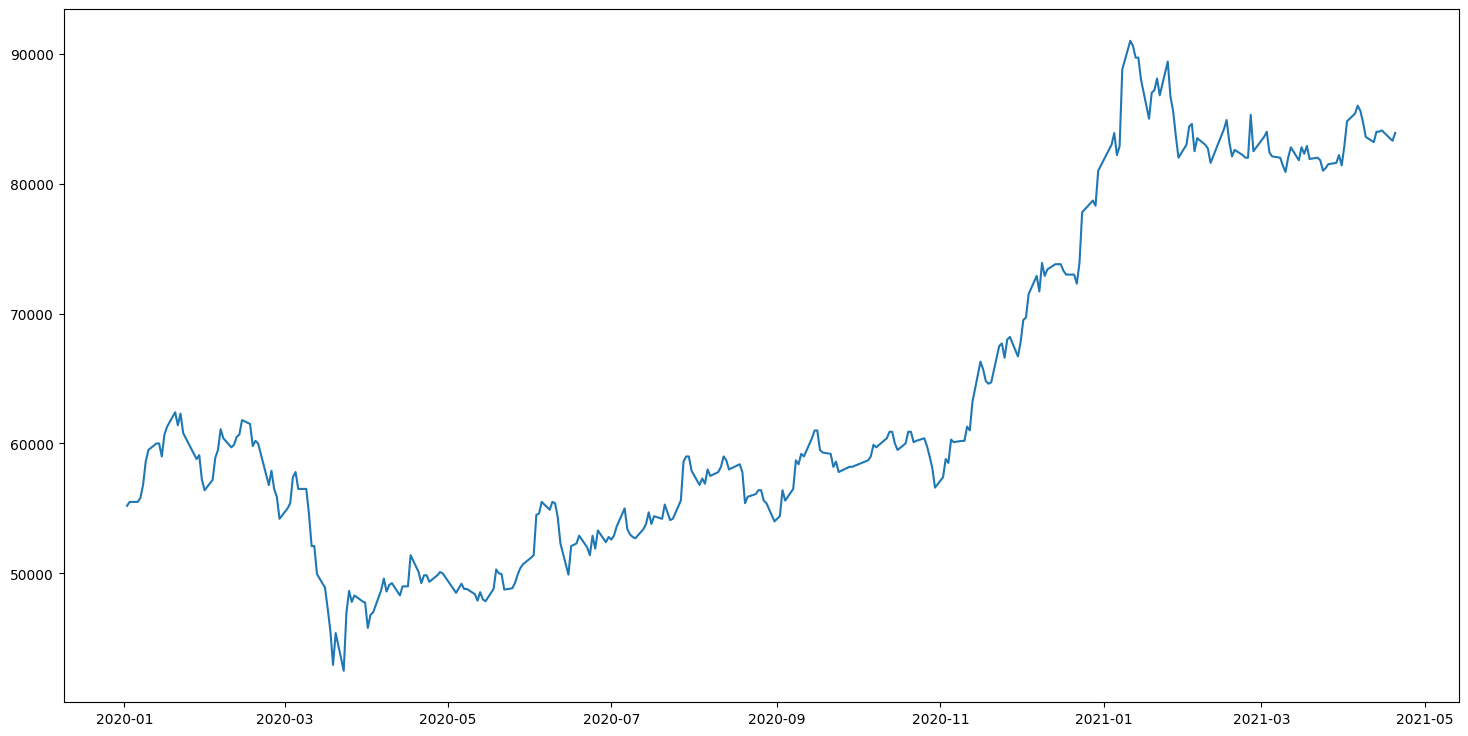

In [5]:
plt.figure(figsize=(18,9))
plt.plot(samsung_df.index, samsung_df["price"], linestyle="-")
plt.xlabel=('Dates')
plt.ylabel=('Price')
plt.show()

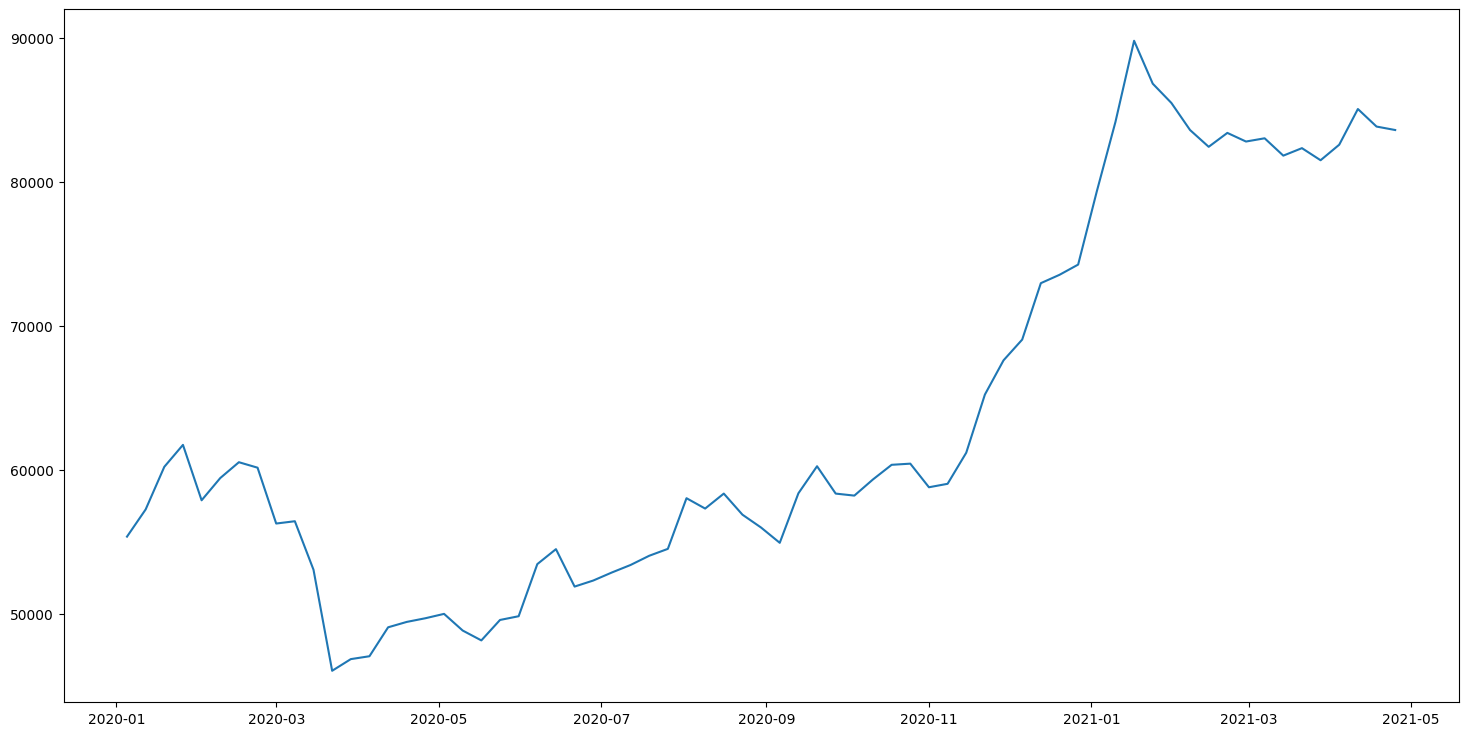

In [10]:
df_week = samsung_df.resample('W').mean()

plt.figure(figsize=(18,9))
plt.plot(df_week.index, df_week["price"], linestyle="-")
plt.xlabel=('Dates')
plt.ylabel=('Price')
plt.show()

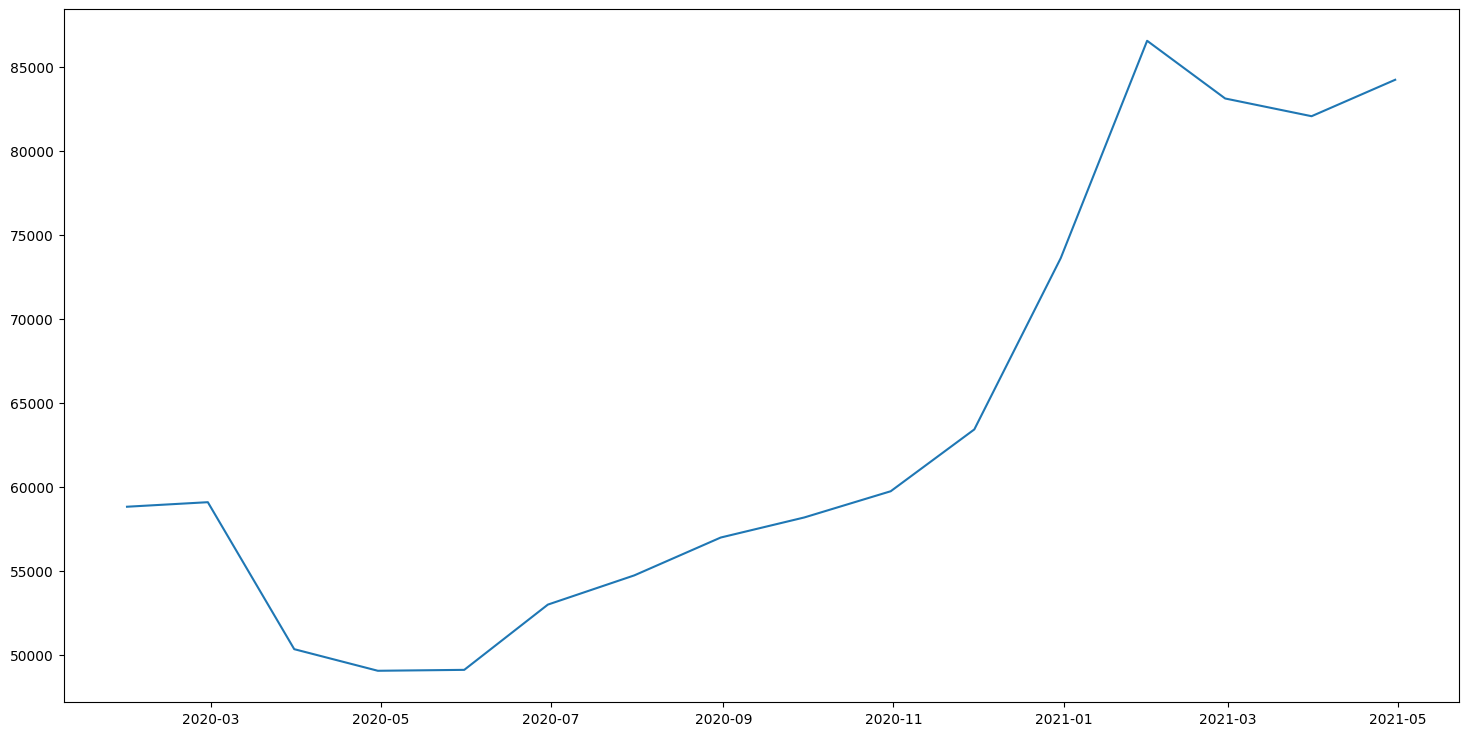

In [11]:
df_month = samsung_df.resample('M').mean()

plt.figure(figsize=(18,9))
plt.plot(df_month.index, df_month["price"], linestyle="-")
plt.xlabel=('Dates')
plt.ylabel=('Price')
plt.show()

# Use ARIMA Model

In [12]:
len(df_week)

69

In [13]:
test_data_size = 9

train_data = df_week[:len(df_week) - test_data_size]
test_data = df_week[len(df_week) - test_data_size:]

In [14]:
import itertools
from tqdm import tqdm
import warnings

In [15]:
warnings.filterwarnings(action='ignore')
p = range(0,3)
d = range(1,2)
q = range(0,6)

pdq = list(itertools.product(p,d,q))

aic = []
params = []

with tqdm(total = len(pdq)) as pg:
    for i in pdq:
        pg.update(1)
        try:
            model = SARIMAX(train_data["price"], order=(i))
            model_fit = model.fit()
            aic.append(round(model_fit.aic,2))
            params.append((i))
        except:
            continue

100%|██████████| 18/18 [00:02<00:00,  6.60it/s]


In [18]:
optimal = [(params[i],j) for i,j in enumerate(aic) if j == min(aic)]
model_opt = ARIMA(train_data["price"], order = optimal[0][0])
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                   60
Model:                 ARIMA(2, 1, 3)   Log Likelihood                -533.987
Date:                Mon, 28 Aug 2023   AIC                           1079.974
Time:                        15:09:14   BIC                           1092.440
Sample:                    01-05-2020   HQIC                          1084.840
                         - 02-21-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5538      0.050    -11.048      0.000      -0.652      -0.456
ar.L2         -0.8833      0.052    -16.897      0.000      -0.986      -0.781
ma.L1          0.6396      0.076      8.369      0.000       0.490       0.789
ma.L2          1.0661      0.180      5.911      0.000       0.713       1.420
ma.L3          0.1362      0.066      2.050      0.040       0.006       0.266
sigma2      3.918e+06    4.5e-08   8.71e+13      0.000    3.92e+06    3.92e+06
===================================================================================
Ljung-Box (L1) (Q):                   4.20   Jarque-Bera (JB):                 0.28
Prob(Q):                              0.04   Prob(JB):                         0.87
Heteroskedasticity (H):               1.72   Skew:                             0.16
Prob(H) (two-sided):                  0.23   Kurtosis:                         2.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.25e+29. Standard errors may be unstable.
"""

In [22]:
arima_pred = model_opt_fit.predict(start = len(train_data), end = len(df_week)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

2021-02-28    83247.063936
2021-03-07    83141.280464
2021-03-14    83435.146582
2021-03-21    83365.832006
2021-03-28    83144.650600
2021-04-04    83328.373031
2021-04-11    83421.989785
2021-04-18    83207.861013
2021-04-25    83243.761287
Freq: W-SUN, Name: ARIMA Predictions, dtype: float64

<Axes: >

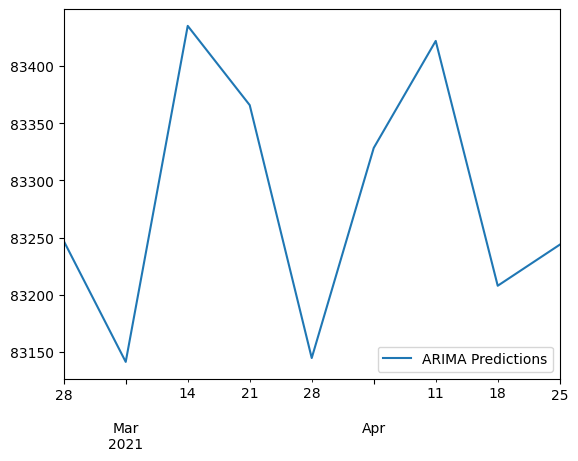

In [24]:
arima_pred.plot(legend = True)

<Axes: xlabel='day'>

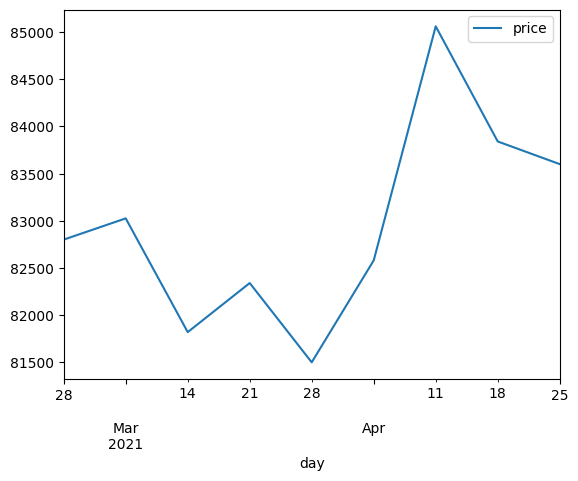

In [25]:
test_data['price'].plot(legend=True)